<a href="https://colab.research.google.com/github/MelissaSequeira/Tomato_Leaf_Disease_Detection/blob/main/IOExDSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"melissargsequeira","key":"d473ee36e668a45af288c098200de964"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           7691        291  1.0              
jaderz/hospital-beds-management                               Hospital Beds Management                                47583  2025-10-03 09:21:58.590000           6302        170  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           9382        212  0.8235294        
ahmadrazakashif

In [4]:
! kaggle datasets download -d 'emmarex/plantdisease'

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 644M/658M [00:03<00:00, 49.6MB/s]
100% 658M/658M [00:03<00:00, 180MB/s] 


In [5]:
!unzip plantdisease.zip -d ./plant_disease_data


Streaming output truncated to the last 5000 lines.
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: ./plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GR

In [6]:
import os
import shutil
m_path="/content/plant_disease_data/PlantVillage"
tomato_path="/content/tomato"
os.makedirs(tomato_path,exist_ok=True)

for folder in os.listdir(m_path):
  if folder.startswith("Tomato"):
    shutil.move(os.path.join(m_path, folder), os.path.join(tomato_path, folder))

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


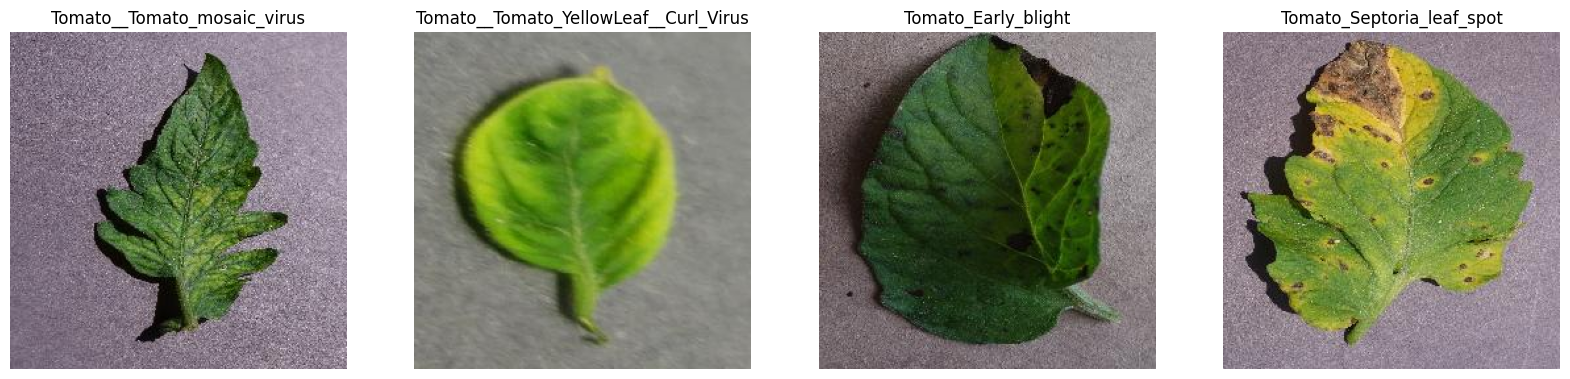

In [27]:
import cv2
base_path = '/content/tomato'
categories = os.listdir(base_path)

plt.figure(figsize=(20,6))
for i, cat in enumerate(categories[:4]):
    path = os.path.join(base_path, cat)
    if os.path.isdir(path):
        img_files = os.listdir(path)
        if img_files:
            img = cv2.imread(os.path.join(path, img_files[0]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1,4,i+1)
            plt.imshow(img)
            plt.title(cat)
            plt.axis('off')
plt.show()

In [8]:
data_dir="/content/tomato"
base_dir="/content/tomato_split"

In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

In [10]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    images = [os.path.join(class_path, img) for img in images]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    # Second split → validation & test (from temp)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)  # 0.33 of 0.3 = ~10%

    # Create class folders inside each split directory
    for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(base_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy files
        for img_path in split_imgs:
            shutil.copy(img_path, split_class_dir)


In [11]:
for folder in ['train', 'val', 'test']:
    path = os.path.join(base_dir, folder)
    print(folder, ":", sum([len(files) for _, _, files in os.walk(path)]))


train : 11204
val : 3218
test : 1590


In [12]:
train_dir = "/content/tomato_split/train"
val_dir = "/content/tomato_split/val"
test_dir = "/content/tomato_split/test"


In [13]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [14]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),   # resize all images
    batch_size=32,
    class_mode='categorical'  # since multiple classes
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False              # important: don’t shuffle for evaluation
)


Found 11203 images belonging to 10 classes.
Found 3218 images belonging to 10 classes.
Found 1590 images belonging to 10 classes.


In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history=model.fit(
    train_data,
    epochs=10,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 153ms/step - accuracy: 0.4665 - loss: 1.5942
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.7722 - loss: 0.6513
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - accuracy: 0.8224 - loss: 0.5037
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.8624 - loss: 0.3886
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.8842 - loss: 0.3304
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.8975 - loss: 0.2917
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.9096 - loss: 0.2654
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.9089 - loss: 0.2585
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - accuracy: 0.9236 - loss: 0.2169
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.9360 - loss: 0.1892


In [18]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8268 - loss: 0.5834
Test Accuracy: 84.65%
Test Loss: 0.5404


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


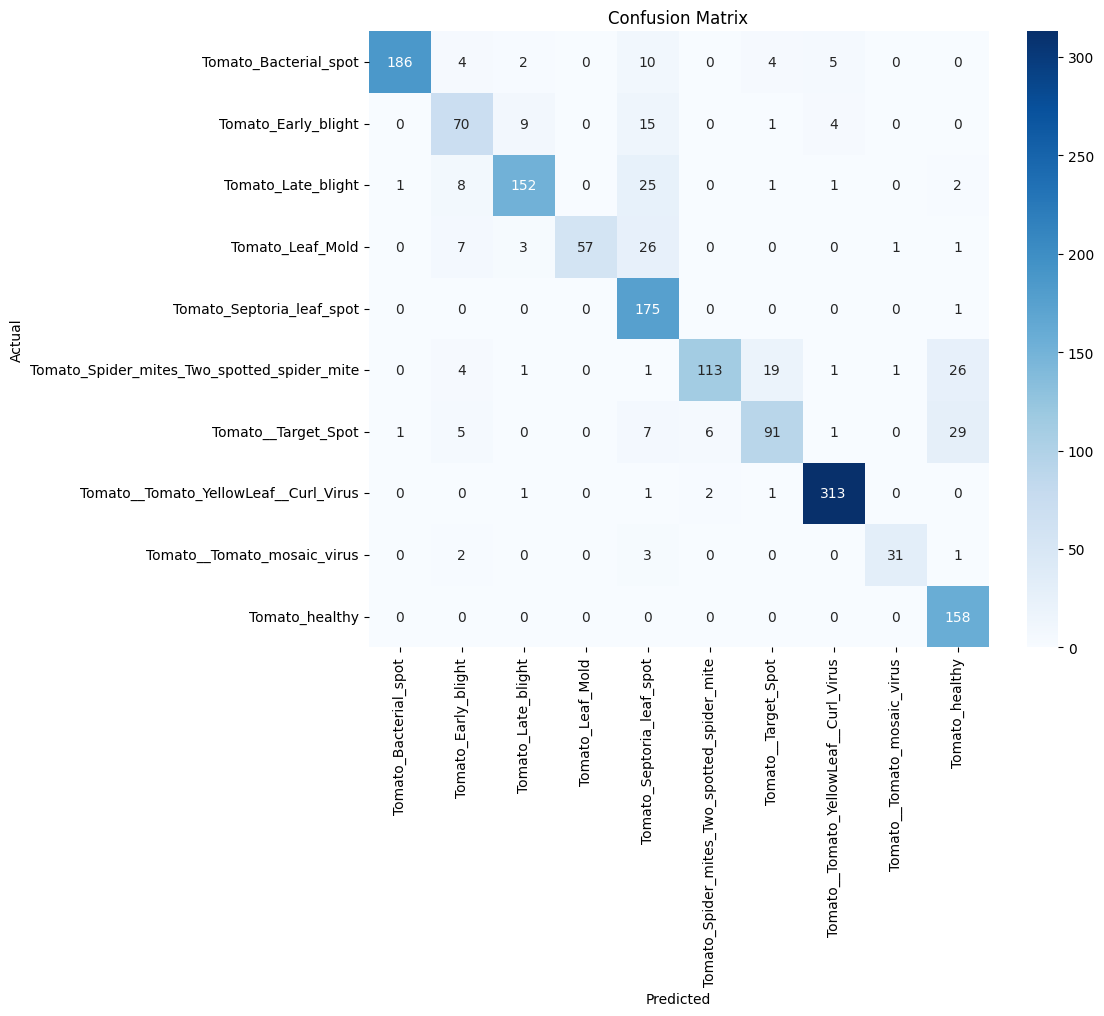


Classification Metrics:
Accuracy:  84.65%
Precision: 86.89%
Recall:    84.65%
F1-score:  84.55%
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.99      0.88      0.93       211
                        Tomato_Early_blight       0.70      0.71      0.70        99
                         Tomato_Late_blight       0.90      0.80      0.85       190
                           Tomato_Leaf_Mold       1.00      0.60      0.75        95
                  Tomato_Septoria_leaf_spot       0.67      0.99      0.80       176
Tomato_Spider_mites_Two_spotted_spider_mite       0.93      0.68      0.79       166
                        Tomato__Target_Spot       0.78      0.65      0.71       140
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.96      0.98      0.97       318
                Tomato__Tomato_mosaic_virus       0.94      0.84      0.89        37
                             Tomato_healthy       0.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_data.class_indices.keys()),
            yticklabels=list(test_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1-score:  {f1 * 100:.2f}%")
print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))


In [20]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [21]:
from tensorflow.keras.optimizers import Adam, RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_opt = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9443 - loss: 0.1634

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 177ms/step - accuracy: 0.9443 - loss: 0.1634 - val_accuracy: 0.7778 - val_loss: 1.0645
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.9515 - loss: 0.1440 - val_accuracy: 0.7865 - val_loss: 0.9517
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.9507 - loss: 0.1372 - val_accuracy: 0.7498 - val_loss: 1.4694
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.9510 - loss: 0.1382 - val_accuracy: 0.8676 - val_loss: 0.5081
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - accuracy: 0.9550 - loss: 0.1317 - val_accuracy: 0.8841 - val_loss: 0.4041
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - accuracy: 0.9564 - loss: 0.1257 - val_accuracy: 0.7579 - val_loss: 1.2424
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.9568 - loss: 0.1151 - val_accuracy: 0.8334 - val_loss: 0.7285
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.9596 - loss: 0.1117 - val

In [22]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\n Optimized Test Accuracy: {test_acc*100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8938 - loss: 0.4238

 Optimized Test Accuracy: 88.43%


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127813 (\N{TOMATO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


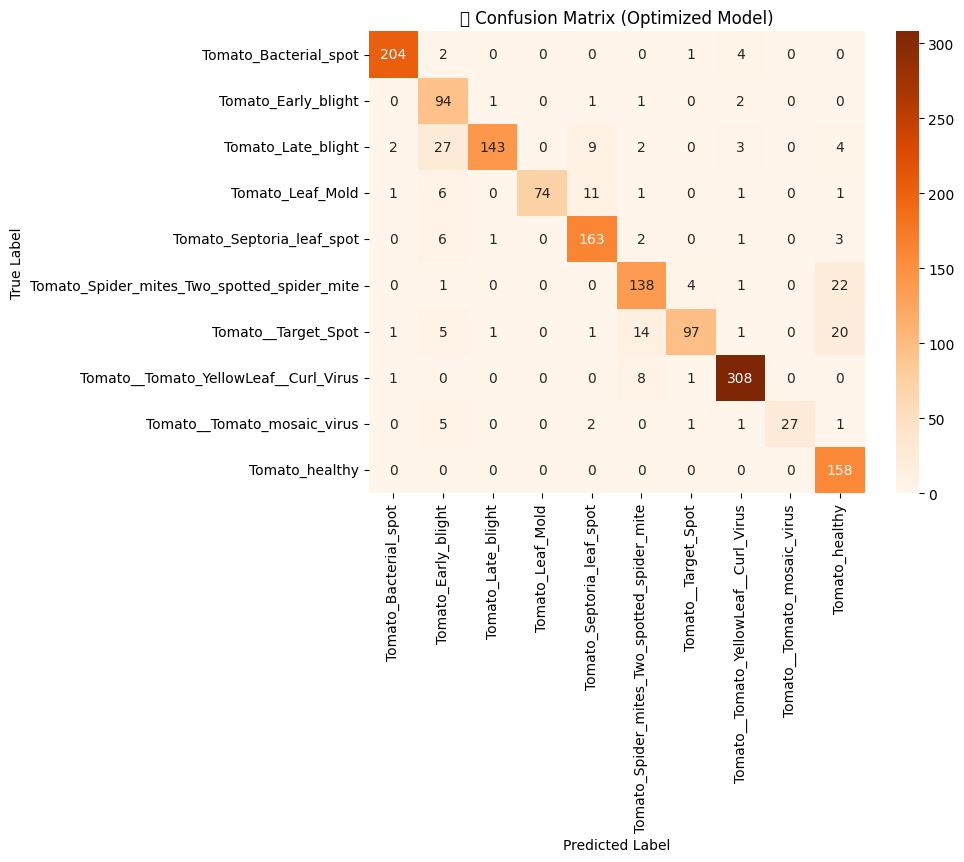


📊 Classification Report (Optimized Model):

Accuracy:  88.43%
Precision: 90.15%
Recall:    88.43%
F1-score:  88.46%

Detailed per-class metrics:

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.98      0.97      0.97       211
                        Tomato_Early_blight       0.64      0.95      0.77        99
                         Tomato_Late_blight       0.98      0.75      0.85       190
                           Tomato_Leaf_Mold       1.00      0.78      0.88        95
                  Tomato_Septoria_leaf_spot       0.87      0.93      0.90       176
Tomato_Spider_mites_Two_spotted_spider_mite       0.83      0.83      0.83       166
                        Tomato__Target_Spot       0.93      0.69      0.80       140
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.96      0.97      0.96       318
                Tomato__Tomato_mosaic_virus       1.00      0.73      0.84        37
  

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# ✅ Confusion Matrix & Classification Report (Optimized Model)
# ============================================

# Get predictions on test data again using the optimized model
Y_pred_opt = model.predict(test_data)
y_pred_opt = np.argmax(Y_pred_opt, axis=1)
y_true = test_data.classes

# Confusion Matrix
cm_opt = confusion_matrix(y_true, y_pred_opt)

plt.figure(figsize=(8,6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Oranges',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.title('🍅 Confusion Matrix (Optimized Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================================
# ✅ Classification Metrics
# ============================================
accuracy = accuracy_score(y_true, y_pred_opt)
precision = precision_score(y_true, y_pred_opt, average='weighted')
recall = recall_score(y_true, y_pred_opt, average='weighted')
f1 = f1_score(y_true, y_pred_opt, average='weighted')

print("\n📊 Classification Report (Optimized Model):\n")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1-score:  {f1 * 100:.2f}%")

# Full detailed class-wise report
print("\nDetailed per-class metrics:\n")
print(classification_report(y_true, y_pred_opt,
                            target_names=test_data.class_indices.keys()))


In [23]:
model.save("tomato_cnn_model.h5")
print(" Model saved successfully!")

 Model saved successfully!
